<a href="https://colab.research.google.com/github/Cado87/keras/blob/main/Transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference**: https://keras.io/guides/transfer_learning/

In [1]:
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
import tensorflow as tf # Import tensorflow
from tensorflow.keras import layers # Import the layers module from tensorflow.keras
from tensorflow import data as tf_data
import numpy as np # Import numpy and alias it as np
from tensorflow import keras # Import keras from tensorflow

In [2]:
#Download images

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


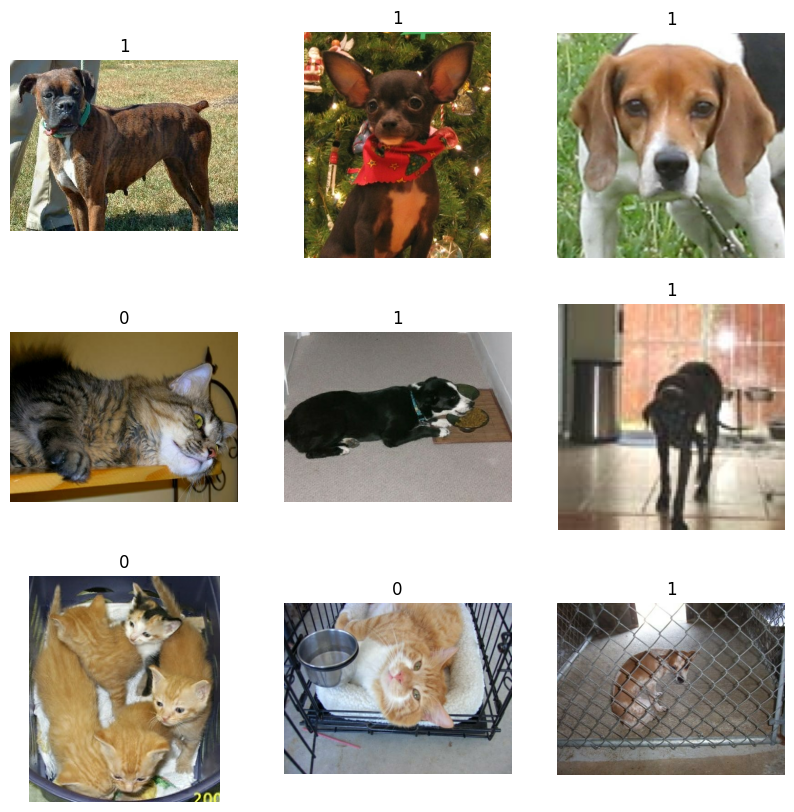

In [3]:
#See examples

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
#Resize images to 150x150
resize_fn = tf.keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [5]:
#Data augmentation

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [6]:
# batch the data and use prefetching to optimize loading speed

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

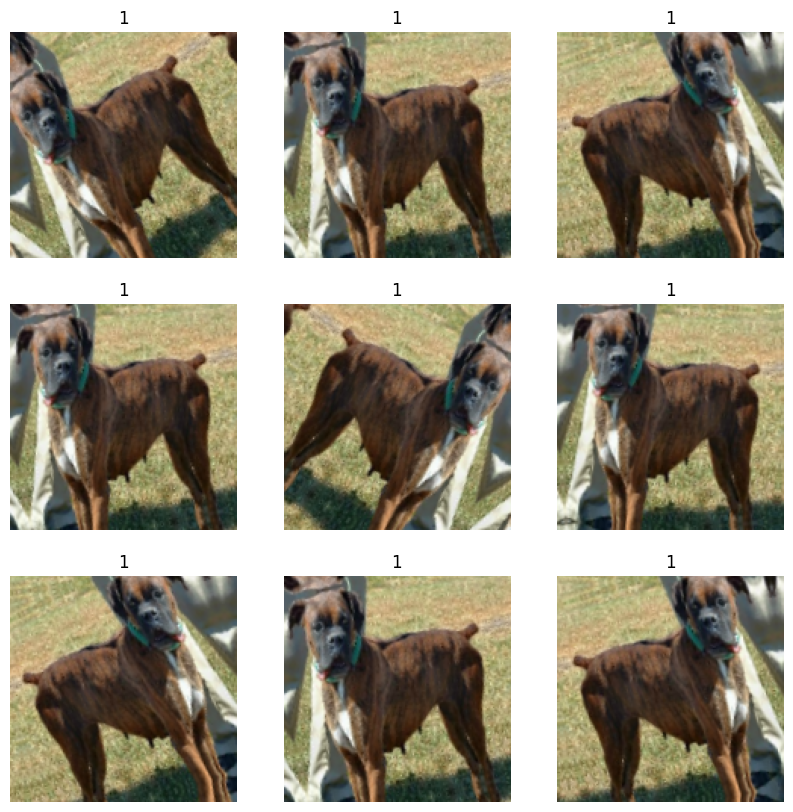

In [7]:
# visualize what the first image of the first batch looks like after various random transformations

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [8]:
#Build model

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
#Train top layer

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 85s 482ms/step - binary_accuracy: 0.8607 - loss: 0.2869 - val_binary_accuracy: 0.9647 - val_loss: 0.0886
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - binary_accuracy: 0.9454 - loss: 0.1279 - val_binary_accuracy: 0.9656 - val_loss: 0.0807


In [10]:
# Fine-tuning

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fitting the end-to-end model
146/146 ━━━━━━━━━━━━━━━━━━━━ 138s 591ms/step - binary_accuracy: 0.8568 - loss: 0.3605 - val_binary_accuracy: 0.9600 - val_loss: 0.1002


In [11]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - binary_accuracy: 0.9624 - loss: 0.0931


[0.10426980257034302, 0.9570077657699585]